In [1]:
import numpy as np # linear algebra
import pandas as pd
# from tqdm import tqdm
from tqdm import tqdm_notebook as tqdm
# tqdm.pandas()

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Flatten, TimeDistributed, LeakyReLU, Conv1D, BatchNormalization, MaxPooling1D, AveragePooling1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras import layers, optimizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

import pickle
import Model_function as func

%matplotlib inline
import matplotlib.pyplot as plt8

In [2]:
cluster = 0
with open(f'D:\\庫存健診開發\\data\\Training\\processed\\Cluster_{cluster}_classification_minmax0_Weekly', 'rb') as fp:
    load_list = pickle.load(fp)

In [3]:
X_train, Y_train, X_test, Y_test = load_list[0], load_list[1], load_list[2], load_list[3]

In [4]:
y_train = np.array([item[2] for item in Y_train])

In [87]:
X_train, Y_train, X_val, Y_val = func.validation_split(X_train, Y_train)

In [88]:
len(X_train) + len(X_val)

226459

In [89]:
(len(X_train) == len(Y_train)) and (len(X_val) == len(Y_val)) and (len(X_test) == len(Y_test))

True

In [90]:
y_train, y_val, y_test = func.get_dependent_variable(Y_train, Y_val, Y_test)
y_test

[0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [91]:
y_train_encode, y_val_encode, y_test_encode = func.categorical_transform(y_train), func.categorical_transform(y_val), func.categorical_transform(y_test)

C:\Users\011553\AppData\Local\Continuum\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
C:\Users\011553\AppData\Local\Continuum\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and

In [92]:
y_test_encode

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

In [ ]:
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(np.array(X_train).shape[1], np.array(X_train).shape[2]),padding='causal'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten(name='feature'))
model.add(Dense(128))
model.add(Dropout(0.2))
model.add(Dense(1, activation='linear'))
model.compile(loss='mean_squared_error',
                optimizer=optimizers.Nadam(lr=0.001),
                metrics=['mape'])


model.fit(np.array(X_train), np.array(y_train), validation_data=(np.array(X_val), np.array(y_val)), batch_size = 256, epochs=200, verbose=2)

In [195]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_35 (Conv1D)           (None, 20, 64)            3904      
_________________________________________________________________
conv1d_36 (Conv1D)           (None, 20, 128)           24704     
_________________________________________________________________
conv1d_37 (Conv1D)           (None, 20, 128)           49280     
_________________________________________________________________
dropout_17 (Dropout)         (None, 20, 128)           0         
_________________________________________________________________
feature (Flatten)            (None, 2560)              0         
_________________________________________________________________
dense_17 (Dense)             (None, 128)               327808    
_________________________________________________________________
dropout_18 (Dropout)         (None, 128)             

In [194]:
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(np.array(X_train).shape[1], np.array(X_train).shape[2]), padding='causal'))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu', padding='causal'))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu', padding='causal'))
model.add(Dropout(0.2))
model.add(Flatten(name='feature'))
model.add(Dense(128))
model.add(Dropout(0.2))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy',
                optimizer=optimizers.Nadam(lr=0.001),
                metrics=[tf.keras.metrics.AUC()])
    
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
model.fit(np.array(X_train), y_train_encode, validation_data=(np.array(X_val), y_val_encode), batch_size = 256, epochs=150, verbose=2)

Train on 215137 samples, validate on 11322 samples
Epoch 1/150
215137/215137 - 5s - loss: 0.6761 - auc_5: 0.6083 - val_loss: 0.6696 - val_auc_5: 0.6248
Epoch 2/150


KeyboardInterrupt: 

In [125]:
from tensorflow.keras.models import Model
intermediate_layer_model = Model(inputs=model.input, outputs=model.get_layer('feature').output)
training_feature = intermediate_layer_model.predict(np.array(X_train))
val_feature = intermediate_layer_model.predict(np.array(X_val))

In [126]:
training_feature.shape

(215137, 2560)

In [7]:
from xgboost import XGBClassifier
xgbc = XGBClassifier(silent=False, 
                      colsample_bytree = 0.8,
                      subsample = 0.8,
                      n_estimators=100, 
                      max_depth=6, 
                      gamma=0.01,
                    tree_method='gpu_hist')

xgbc.fit(np.array(X_train).reshape(len(X_train), 20*20), np.array(y_train), eval_set = [(np.array(X_train).reshape(len(X_train), 20*20), np.array(y_train))], verbose=True, eval_metric='auc')


XGBoostError: [16:54:21] D:\Build\xgboost\xgboost-0.90.git\src\learner.cc:180: XGBoost version not compiled with GPU support.

In [130]:
testing_feature = intermediate_layer_model.predict(np.array(X_test))

In [132]:
xgbc.score(testing_feature, np.array(y_test))
prediction = xgbc.predict(testing_feature)

In [138]:
xgbc.score(val_feature, np.array(y_val))

0.6136724960254372

In [149]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(n_estimators = 400, max_depth=20, verbose=1, n_jobs=-1)
forest.fit(training_feature, np.array(y_train))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   15.2s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  2.9min finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=20, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)

In [180]:
prediction = forest.predict(testing_feature)
prediction_train = forest.predict(training_feature)
prediction_val = forest.predict(val_feature)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.3s
[Parallel(n_jobs=12)]: Done 400 out of 400 | elapsed:    0.9s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.5s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    3.0s
[Parallel(n_jobs=12)]: Done 400 out of 400 | elapsed:    6.8s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 400 out of 400 | elapsed:    0.3s finished


In [151]:
fpr, tpr, thresholds = metrics.roc_curve(np.array(y_test), prediction)
auc = metrics.auc(fpr, tpr)
print(auc)

0.6591658660407058


In [177]:
prediction = xgbc.predict(testing_feature)
prediction_train = xgbc.predict(training_feature)
prediction_val = xgbc.predict(val_feature)

In [152]:
from sklearn.metrics import classification_report
target_names = ['down', 'up']        
report_test = classification_report(np.array(y_test), prediction, target_names=target_names)
report_train = classification_report(np.array(y_train), prediction_train, target_names=target_names)
report_val = classification_report(np.array(y_val), prediction_val, target_names=target_names)

In [153]:
print(report_test)
print(report_train)
print(report_val)

              precision    recall  f1-score   support

        down       0.64      0.68      0.66     15014
          up       0.67      0.64      0.66     15681

    accuracy                           0.66     30695
   macro avg       0.66      0.66      0.66     30695
weighted avg       0.66      0.66      0.66     30695

              precision    recall  f1-score   support

        down       0.80      0.87      0.83    108465
          up       0.86      0.78      0.81    106672

    accuracy                           0.82    215137
   macro avg       0.83      0.82      0.82    215137
weighted avg       0.83      0.82      0.82    215137

              precision    recall  f1-score   support

        down       0.62      0.67      0.64      5718
          up       0.63      0.58      0.61      5604

    accuracy                           0.62     11322
   macro avg       0.62      0.62      0.62     11322
weighted avg       0.62      0.62      0.62     11322



In [157]:
def Separate_Evaluation(Real, prediction, **kwargs):
    
    y_pred = prediction.tolist()
        
    if len(kwargs.keys()) == 1:
            if 'year' in kwargs:
                    value = kwargs['year']
                    y_true = [sublist[2] for sublist in Real if sublist[0].year == value]  
                    y_index = [i for i, sublist in enumerate(Real) if sublist[0].year == value]
            else:
                    value = kwargs['stock']
                    y_true = [sublist[2] for sublist in Real if sublist[1] == value]  
                    y_index = [i for i, sublist in enumerate(Real) if sublist[1] == value]

    else:
            year = kwargs['year']
            stock = kwargs['stock']
            y_true = [sublist[2] for sublist in Real if (sublist[0].year == year) and (sublist[1] == stock)]  
            y_index = [i for i, sublist in enumerate(Real) if (sublist[0].year == year) and (sublist[1] == stock)]

    y = [y_pred[i] for i in y_index]
        
    correct = 0
    for i, item in enumerate(y):
        if item == y_true[i]:
            correct += 1
        else:
            continue
                
    target_names = ['down', 'up']
        
    report = classification_report(y_true, y, target_names=target_names)
    accuracy = correct/len(y)
        

    return report, accuracy


In [191]:
stock_list = pd.Series([sublist[1] for sublist in Y_test]).unique().tolist()
acc = []
for stock in stock_list:
    report, accuracy = Separate_Evaluation(Y_test, prediction, year=2017, stock=stock)
    acc.append(accuracy)
    print(stock)
    print(report)

1301
              precision    recall  f1-score   support

        down       0.52      0.67      0.58        24
          up       0.72      0.58      0.65        36

    accuracy                           0.62        60
   macro avg       0.62      0.62      0.61        60
weighted avg       0.64      0.62      0.62        60

1402
              precision    recall  f1-score   support

        down       0.47      0.65      0.55        23
          up       0.71      0.54      0.62        37

    accuracy                           0.58        60
   macro avg       0.59      0.60      0.58        60
weighted avg       0.62      0.58      0.59        60

2105
              precision    recall  f1-score   support

        down       0.84      0.98      0.90        48
          up       0.75      0.25      0.38        12

    accuracy                           0.83        60
   macro avg       0.79      0.61      0.64        60
weighted avg       0.82      0.83      0.80        60

1216


2454
              precision    recall  f1-score   support

        down       0.52      0.45      0.48        31
          up       0.48      0.55      0.52        29

    accuracy                           0.50        60
   macro avg       0.50      0.50      0.50        60
weighted avg       0.50      0.50      0.50        60

2542
              precision    recall  f1-score   support

        down       0.60      0.78      0.68        32
          up       0.61      0.39      0.48        28

    accuracy                           0.60        60
   macro avg       0.60      0.59      0.58        60
weighted avg       0.60      0.60      0.58        60

2474
              precision    recall  f1-score   support

        down       0.43      0.45      0.44        29
          up       0.47      0.45      0.46        31

    accuracy                           0.45        60
   macro avg       0.45      0.45      0.45        60
weighted avg       0.45      0.45      0.45        60

261

ValueError: Number of classes, 0, does not match size of target_names, 2. Try specifying the labels parameter

In [193]:
t = [i for i in acc if i < 0.55]
len(t)/len(acc)

0.22916666666666666

In [179]:
stock_list = pd.Series([sublist[1] for sublist in Y_test]).unique().tolist()
acc = []
for stock in stock_list:
    report, accuracy = Separate_Evaluation(Y_test, prediction, year=2019, stock=stock)
    acc.append(accuracy)
    print(stock)
    print(report)

1301
              precision    recall  f1-score   support

        down       0.71      0.60      0.65        83
          up       0.68      0.78      0.73        90

    accuracy                           0.69       173
   macro avg       0.70      0.69      0.69       173
weighted avg       0.70      0.69      0.69       173

1402
              precision    recall  f1-score   support

        down       0.68      0.66      0.67        74
          up       0.75      0.77      0.76        99

    accuracy                           0.72       173
   macro avg       0.72      0.71      0.72       173
weighted avg       0.72      0.72      0.72       173

2105
              precision    recall  f1-score   support

        down       0.61      0.66      0.64        82
          up       0.67      0.63      0.65        91

    accuracy                           0.64       173
   macro avg       0.64      0.64      0.64       173
weighted avg       0.64      0.64      0.64       173

1216


2454
              precision    recall  f1-score   support

        down       0.39      0.61      0.48        57
          up       0.74      0.53      0.62       116

    accuracy                           0.56       173
   macro avg       0.57      0.57      0.55       173
weighted avg       0.62      0.56      0.57       173

2542
              precision    recall  f1-score   support

        down       0.73      0.68      0.70        80
          up       0.74      0.78      0.76        93

    accuracy                           0.73       173
   macro avg       0.73      0.73      0.73       173
weighted avg       0.73      0.73      0.73       173

2474
              precision    recall  f1-score   support

        down       0.45      0.61      0.52        80
          up       0.52      0.37      0.43        93

    accuracy                           0.48       173
   macro avg       0.49      0.49      0.48       173
weighted avg       0.49      0.48      0.47       173

261


2912
              precision    recall  f1-score   support

        down       0.59      0.64      0.62        98
          up       0.48      0.43      0.45        75

    accuracy                           0.55       173
   macro avg       0.54      0.53      0.53       173
weighted avg       0.54      0.55      0.55       173

2915
              precision    recall  f1-score   support

        down       0.73      0.84      0.78       111
          up       0.61      0.45      0.52        62

    accuracy                           0.70       173
   macro avg       0.67      0.64      0.65       173
weighted avg       0.69      0.70      0.69       173

3008
              precision    recall  f1-score   support

        down       0.31      0.28      0.29        80
          up       0.44      0.48      0.46        93

    accuracy                           0.39       173
   macro avg       0.38      0.38      0.38       173
weighted avg       0.38      0.39      0.38       173

370

In [178]:
for year in [2017, 2018, 2019]:
    report, accuracy = Separate_Evaluation(Y_test, prediction, year=year)
    print(accuracy)
    print(report)

0.6145502645502645
              precision    recall  f1-score   support

        down       0.61      0.65      0.63      1920
          up       0.61      0.58      0.60      1860

    accuracy                           0.61      3780
   macro avg       0.61      0.61      0.61      3780
weighted avg       0.61      0.61      0.61      3780

0.6520740268028079
              precision    recall  f1-score   support

        down       0.66      0.68      0.67      8100
          up       0.65      0.62      0.63      7570

    accuracy                           0.65     15670
   macro avg       0.65      0.65      0.65     15670
weighted avg       0.65      0.65      0.65     15670

0.6650066696309471
              precision    recall  f1-score   support

        down       0.62      0.64      0.63      4994
          up       0.70      0.68      0.69      6251

    accuracy                           0.67     11245
   macro avg       0.66      0.66      0.66     11245
weighted avg     

In [174]:
first_year = [sublist[2] for sublist in Y_test if sublist[0].year == 2017]
second_year = [sublist[2] for sublist in Y_test if sublist[0].year == 2018]
third_year = [sublist[2] for sublist in Y_test if sublist[0].year == 2019]

In [175]:
print(first_year.count(1)/len(first_year))
print(second_year.count(1)/len(second_year))
print(third_year.count(1)/len(third_year))

0.49206349206349204
0.4830887045309509
0.5558915073365941


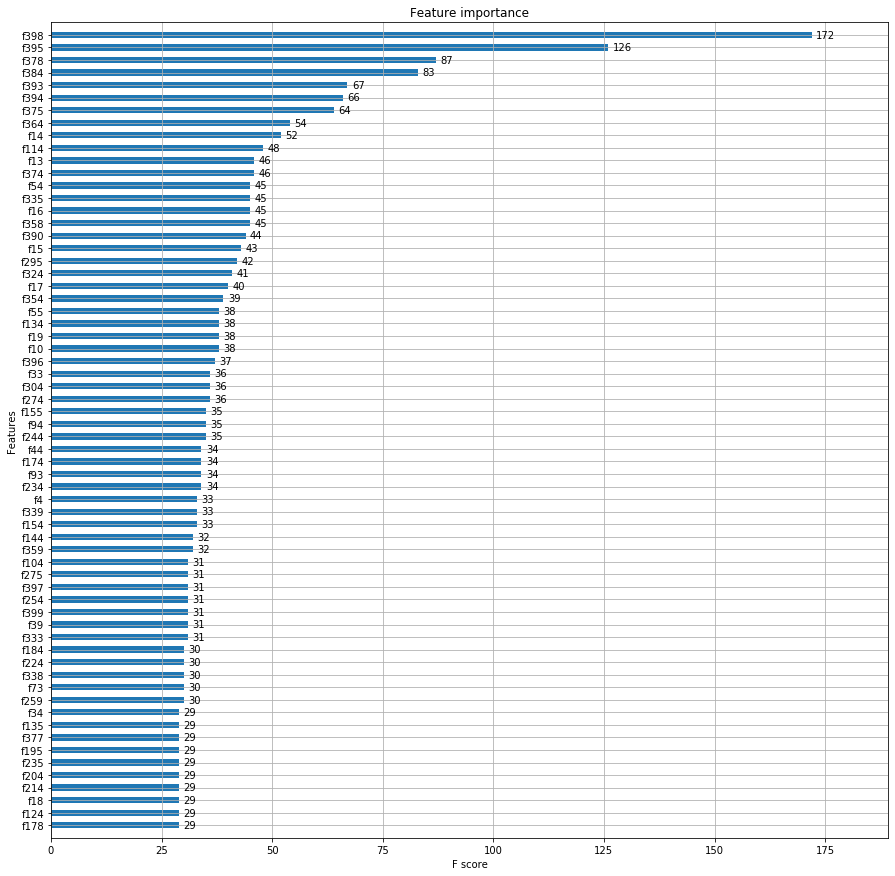

In [50]:
from xgboost import plot_importance
from matplotlib import pyplot
fig,ax = plt.subplots(figsize=(15,15))
plot_importance(xgbc,
                height=0.5,
                ax=ax,
                max_num_features=64)

In [119]:
score = model.evaluate(np.array(X_test), y_test_encode, batch_size=4096)

30695/30695 [==============================] - ETA: 0s - loss: 0.7076 - auc_4: 0.681 - ETA: 0s - loss: 0.7025 - auc_4: 0.673 - ETA: 0s - loss: 0.6942 - auc_4: 0.681 - 0s 5us/sample - loss: 0.6922 - auc_4: 0.6814


In [120]:
score

[0.6921923757550926, 0.6814309]

In [115]:
prediction = model.predict(np.array(X_val))

In [116]:
y_pred = [item.index(max(item)) for item in prediction.tolist()]

In [111]:
from sklearn.metrics import classification_report
target_names = ['down', 'up']        
report = classification_report(y_test, y_pred, target_names=target_names)
print(report)

              precision    recall  f1-score   support

        down       0.62      0.66      0.64     15014
          up       0.66      0.62      0.64     15681

    accuracy                           0.64     30695
   macro avg       0.64      0.64      0.64     30695
weighted avg       0.64      0.64      0.64     30695



In [114]:
from sklearn.metrics import classification_report
target_names = ['down', 'up']        
report = classification_report(y_train, y_pred, target_names=target_names)
print(report)

              precision    recall  f1-score   support

        down       0.60      0.64      0.62    108465
          up       0.61      0.56      0.58    106672

    accuracy                           0.60    215137
   macro avg       0.60      0.60      0.60    215137
weighted avg       0.60      0.60      0.60    215137



In [117]:
from sklearn.metrics import classification_report
target_names = ['down', 'up']        
report = classification_report(y_val, y_pred, target_names=target_names)
print(report)

              precision    recall  f1-score   support

        down       0.59      0.64      0.61      5718
          up       0.60      0.55      0.57      5604

    accuracy                           0.59     11322
   macro avg       0.60      0.59      0.59     11322
weighted avg       0.60      0.59      0.59     11322

